In [53]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
from PIL import Image
import random


In [54]:
data_dir = 'Train'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='training', seed=123, image_size=(224, 224), batch_size=120)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='validation', seed=123, image_size=(224, 224), batch_size=120)

apple_dir = 'Use'

apple_ds = tf.keras.utils.image_dataset_from_directory(
    apple_dir, image_size=(224, 224), labels = None)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 382 files belonging to 4 classes.
Using 306 files for training.
Found 382 files belonging to 4 classes.
Using 76 files for validation.
Found 120 files belonging to 4 classes.
Found 317 files belonging to 1 classes.


In [55]:
# Preprocess: klaar voor modelX
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Rescale:
tf.keras.layers.Rescaling(scale=1./255)

# Add augmentation:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)])

In [56]:

img_height = 224
img_width = 224
IMG_SIZE = img_width, img_height
IMG_SHAPE = IMG_SIZE + (3,)

# Create the base model from the pre-trained model MobileNet V2

# Model van MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# base_model.summary()

In [57]:
base_model.trainable = False

In [58]:
# Feature extraction

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(120, 7, 7, 1280)
(120, 1280)


In [59]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(120, 4)


In [60]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = tf.keras.layers.Rescaling(scale=1./255)(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)

modelX = tf.keras.Model(inputs, outputs)

In [61]:
#optimaliseren
base_learning_rate = 0.0001
modelX.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

modelX.summary()

len(modelX.trainable_variables)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5124

2

In [62]:
initial_epochs = 25

loss0, accuracy0 = modelX.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

1/1 [==============================] - 2s 2s/step - loss: 1.8716 - accuracy: 0.1579
initial loss: 1.87
initial accuracy: 0.16


In [63]:
history = modelX.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/27
3/3 [==============================] - 6s 1s/step - loss: 1.7982 - accuracy: 0.2582 - val_loss: 1.8169 - val_accuracy: 0.1579
Epoch 2/27
3/3 [==============================] - 4s 1s/step - loss: 1.7548 - accuracy: 0.2810 - val_loss: 1.7694 - val_accuracy: 0.1447
Epoch 3/27
3/3 [==============================] - 4s 1s/step - loss: 1.6867 - accuracy: 0.2843 - val_loss: 1.7258 - val_accuracy: 0.1579
Epoch 4/27
3/3 [==============================] - 4s 1s/step - loss: 1.7041 - accuracy: 0.2745 - val_loss: 1.6851 - val_accuracy: 0.1579
Epoch 5/27
3/3 [==============================] - 5s 2s/step - loss: 1.6512 - accuracy: 0.2810 - val_loss: 1.6476 - val_accuracy: 0.1842
Epoch 6/27
3/3 [==============================] - 5s 2s/step - loss: 1.6478 - accuracy: 0.3072 - val_loss: 1.6125 - val_accuracy: 0.1711
Epoch 7/27
3/3 [==============================] - 5s 2s/step - loss: 1.5911 - accuracy: 0.3007 - val_loss: 1.5798 - val_accuracy: 0.1974
Epoch 8/27
3/3 [=========================

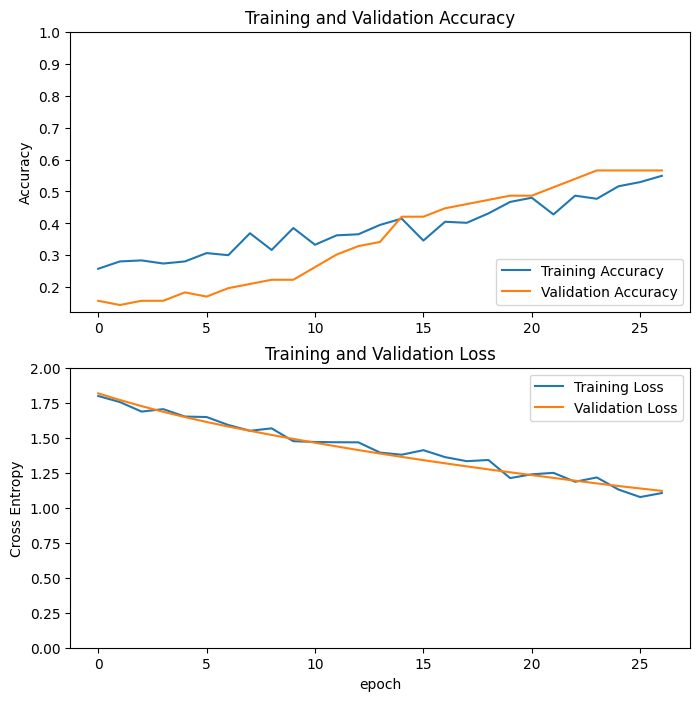

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [65]:
# Unfreeze
# MobileNet

base_model.trainable = True

In [66]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [67]:
#learnig rate delen door 10
modelX.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

modelX.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 5124

In [16]:
len(modelX.trainable_variables)
#vanaf 100 dus 100 ook en 154 ook

56

In [68]:
# Continue training

fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = modelX.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 27/40
3/3 [==============================] - 8s 2s/step - loss: 1.0784 - accuracy: 0.5490 - val_loss: 0.9094 - val_accuracy: 0.6974
Epoch 28/40
3/3 [==============================] - 6s 2s/step - loss: 0.7442 - accuracy: 0.7157 - val_loss: 0.7211 - val_accuracy: 0.7895
Epoch 29/40
3/3 [==============================] - 7s 2s/step - loss: 0.6245 - accuracy: 0.7876 - val_loss: 0.6396 - val_accuracy: 0.7895
Epoch 30/40
3/3 [==============================] - 7s 2s/step - loss: 0.5665 - accuracy: 0.8105 - val_loss: 0.5840 - val_accuracy: 0.7895
Epoch 31/40
3/3 [==============================] - 7s 2s/step - loss: 0.4930 - accuracy: 0.8497 - val_loss: 0.5409 - val_accuracy: 0.8158
Epoch 32/40
3/3 [==============================] - 7s 2s/step - loss: 0.4224 - accuracy: 0.8660 - val_loss: 0.5132 - val_accuracy: 0.7895
Epoch 33/40
3/3 [==============================] - 7s 2s/step - loss: 0.4009 - accuracy: 0.8758 - val_loss: 0.4972 - val_accuracy: 0.8289
Epoch 34/40
3/3 [=================

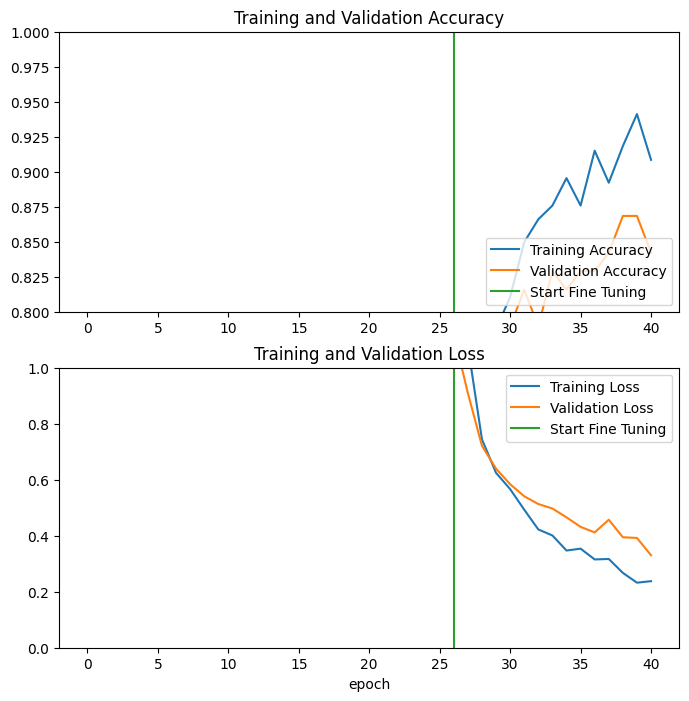

In [69]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [70]:
#evaluatie test accuracy
modelX.evaluate(test_ds)

3/3 [==============================] - 3s 943ms/step - loss: 0.1446 - accuracy: 0.9771


[0.1445566862821579, 0.9771241545677185]

Found 120 files belonging to 4 classes.


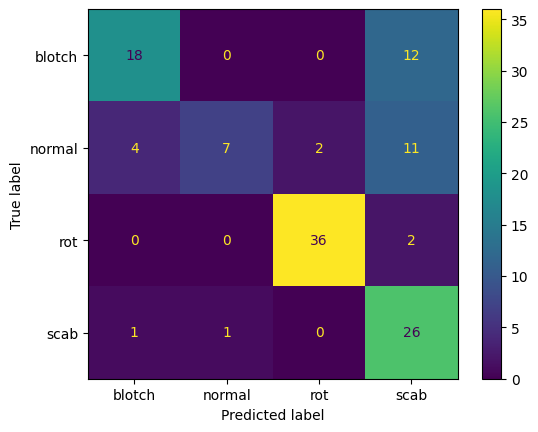

In [79]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay

# test_ds Aanmaken
# andere images dan in train_ds

data_dir = 'test'

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, seed=123, image_size=(224, 224),shuffle = False, batch_size=120)


batchPredictions = modelX.predict(test_ds)

predicted_categories = tf.argmax(batchPredictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0)

cm = confusion_matrix(true_categories, predicted_categories)

cmd = ConfusionMatrixDisplay(cm, display_labels=['blotch','normal','rot','scab'])

cmd.plot()

In [72]:
modelX.save('models/mobilenetv2')

INFO:tensorflow:Assets written to: models/mobilenetv2\assets


In [73]:
batchPredictions = modelX.predict(apple_ds)

predicted_categories = tf.argmax(batchPredictions, axis=1)
print(predicted_categories)

tf.Tensor(
[3 2 1 0 0 2 0 1 1 1 2 2 3 2 2 3 1 0 0 0 3 3 2 0 3 1 2 1 0 0 0 0 2 3 2 2 1
 0 2 0 0 0 2 2 2 2 2 0 2 0 2 2 0 0 0 0 0 2 1 0 0 2 2 2 2 2 1 0 0 1 0 2 0 3
 0 3 0 2 1 2 1 0 0 3 0 0 2 2 2 2 2 2 2 3 3 0 2 2 3 2 0 3 3 2 2 2 2 0 3 2 3
 2 1 3 2 0 2 0 3 3 1 1 3 0 0 0 2 0 0 2 2 0 2 2 1 3 0 1 0 0 0 2 1 2 2 1 0 1
 1 1 2 0 2 2 2 2 3 2 3 2 3 3 3 0 2 3 0 0 0 3 2 0 2 3 2 1 2 1 1 2 2 3 2 3 0
 2 2 3 0 0 3 1 0 0 3 2 2 3 0 1 0 1 3 0 2 0 3 2 0 2 2 3 2 2 1 2 2 0 3 3 2 1
 0 0 0 0 0 2 3 0 2 2 3 2 0 3 0 2 0 3 0 0 0 2 2 0 0 1 0 2 2 0 1 0 0 0 0 2 3
 2 0 3 3 3 2 0 2 1 0 0 2 1 2 0 0 1 0 2 0 0 1 3 0 2 1 3 0 3 3 0 3 0 1 0 0 3
 1 1 0 2 0 0 0 2 3 0 0 0 0 2 2 2 1 2 2 1 3], shape=(317,), dtype=int64)


In [74]:
predicted_categories[0]
predicted_categories[0].numpy().tolist()
samplebatchnp = predicted_categories.numpy()
samplebatchlist = samplebatchnp.tolist()
print(samplebatchlist)
print(samplebatchlist.count(0))
print(samplebatchlist.count(1))
print(samplebatchlist.count(2))
print(samplebatchlist.count(3))

[3, 2, 1, 0, 0, 2, 0, 1, 1, 1, 2, 2, 3, 2, 2, 3, 1, 0, 0, 0, 3, 3, 2, 0, 3, 1, 2, 1, 0, 0, 0, 0, 2, 3, 2, 2, 1, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 2, 2, 2, 2, 1, 0, 0, 1, 0, 2, 0, 3, 0, 3, 0, 2, 1, 2, 1, 0, 0, 3, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 0, 2, 2, 3, 2, 0, 3, 3, 2, 2, 2, 2, 0, 3, 2, 3, 2, 1, 3, 2, 0, 2, 0, 3, 3, 1, 1, 3, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 1, 3, 0, 1, 0, 0, 0, 2, 1, 2, 2, 1, 0, 1, 1, 1, 2, 0, 2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 0, 2, 3, 0, 0, 0, 3, 2, 0, 2, 3, 2, 1, 2, 1, 1, 2, 2, 3, 2, 3, 0, 2, 2, 3, 0, 0, 3, 1, 0, 0, 3, 2, 2, 3, 0, 1, 0, 1, 3, 0, 2, 0, 3, 2, 0, 2, 2, 3, 2, 2, 1, 2, 2, 0, 3, 3, 2, 1, 0, 0, 0, 0, 0, 2, 3, 0, 2, 2, 3, 2, 0, 3, 0, 2, 0, 3, 0, 0, 0, 2, 2, 0, 0, 1, 0, 2, 2, 0, 1, 0, 0, 0, 0, 2, 3, 2, 0, 3, 3, 3, 2, 0, 2, 1, 0, 0, 2, 1, 2, 0, 0, 1, 0, 2, 0, 0, 1, 3, 0, 2, 1, 3, 0, 3, 3, 0, 3, 0, 1, 0, 0, 3, 1, 1, 0, 2, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 1, 3]
110
43
107
57


In [75]:
aqlset_list =(random.choices(samplebatchlist,k = 80))
print(aqlset_list)

[2, 1, 2, 2, 0, 2, 2, 3, 0, 3, 2, 2, 2, 0, 2, 3, 1, 3, 2, 0, 0, 0, 2, 3, 0, 2, 2, 2, 1, 1, 2, 0, 2, 2, 0, 2, 0, 3, 2, 3, 2, 1, 0, 0, 3, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 2, 3, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 3, 0, 2, 1, 3, 3, 2, 0, 1, 3, 0, 0, 2]


In [76]:
blotchApple = aqlset_list.count(0)
HealtyApple = aqlset_list.count(1)
rotApple = aqlset_list.count(2)
scabApple = aqlset_list.count(3)

def AQLTestscore():

    for apple in aqlset_list:
        
        if HealtyApple >=79:
            print (f'The batch has been quallified as: Class 1\n')
        elif HealtyApple >=75:
            print (f'The batch has been quallified as: Class 2\n')
        elif HealtyApple >=73:
            print (f'The batch has been quallified as: Class 3\n')
        else:
            print (f'The batch has been rejected\n')

        print (f'The total batch of {len(aqlset_list)} apples consists of:\n'
        f'Healthy apples: {HealtyApple}\n'
        f'Blotch apples: {blotchApple}\n'
        f'Rot apples: {rotApple}\n'
        f'Scab apples: {scabApple}\n')
        break
    
AQLTestscore()

The batch has been rejected

The total batch of 80 apples consists of:
Healthy apples: 8
Blotch apples: 25
Rot apples: 34
Scab apples: 13



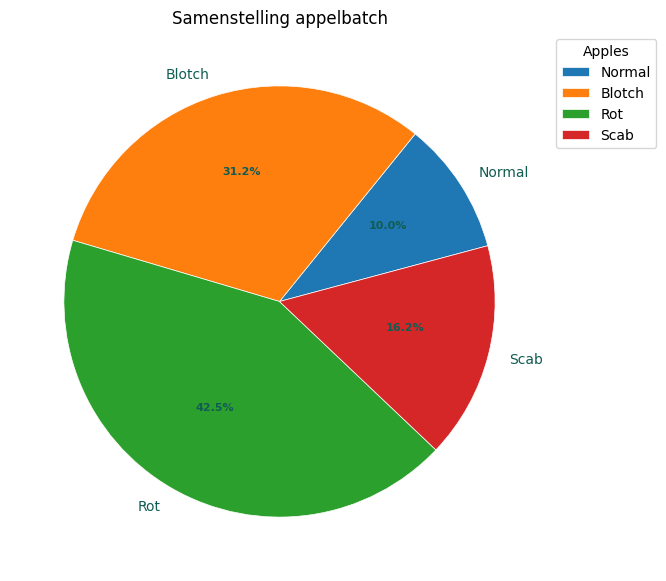

In [77]:
# Creating dataset
appleLabels = ['Normal', 'Blotch', 'Rot', 'Scab']
 
data = [HealtyApple, blotchApple, rotApple, scabApple]

# Creating explode data
explode = (0.0, 0.0, 0.0, 0.0) # not necessary

# Wedge properties
wp = { 'linewidth' : 0.5, 'edgecolor' : "white" }

# Creating autocpt arguments
def func(pct, allvalues):
	absolute = int(pct / 100.*np.sum(allvalues))
	return "{:.1f}%\n".format(pct, absolute)

# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(data,
								autopct = lambda pct: func(pct, data),
								explode = explode,
								labels = appleLabels,
								shadow = False,
								startangle = 15,
								wedgeprops = wp,
								textprops = dict(color ="#115C53"))

# Adding legend
ax.legend(wedges, appleLabels,
		title ="Apples",
		loc ="upper left",
		bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Samenstelling appelbatch") # add Classification as title

#show plot
plt.show() 

In [52]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L12-v2')


accuracyBatch = modelX.evaluate(apple_ds)

sentences = [f'There are {HealtyApple} healthy apples in this batch',
                                  f'The accuracy of this prediction is {accuracyBatch} for loss and accuracyS',
                                  f'This batch contains {rotApple} rotten apple(s)',
                                  f'This batch contains {scabApple} scabbed apple(s)',
                                  f'This batch contains {blotchApple} blotched apple(s)',
                                    'Class 1 are 79 healty apples for example supermarkets ore greengrocer',
                                    'Class 2 are 75 healty apples used for exapmle in applesause',
                                    'Class 3 are 73 healty apples used for syrup',
                                    'A rejected batch can be used for petfood',
                                    'We have 4 types of apples, Blotch, Normal, Rot and Scab',
                                    'A batch consists of 80 apples',
                                    'Am I so smart ore are you so dum',
                                    'The lot size is between 5.000 and 10.000 apples',
                                    'the quality of this batch is to poor']


query_embedding = model.encode(input('what is your question?'), convert_to_tensor=True)
passage_embedding = model.encode(sentences, convert_to_tensor=True)
answerArray = util.dot_score(query_embedding, passage_embedding)

print("Similarity:", answerArray)

answerLocation = answerArray.argmax()

print(sentences[answerLocation.item()])

10/10 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Similarity: tensor([[0.7303, 0.1231, 0.6997, 0.8222, 0.7445, 0.5244, 0.5591, 0.5048, 0.2663,
         0.6579, 0.6964, 0.1206, 0.6090, 0.3676]])
This batch contains 13 scabbed apple(s)
